In [1]:
import earthkit.hydro as ekh
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import earthkit.data as ekd
import earthkit.plots as ekp
import earthkit.plots.quickplot as qplot


# helper function to create plots
def plot(data, norm=mpl.colors.LogNorm()):
    _, ax = plt.subplots()
    ax.contourf(data, norm=norm)
    ax.invert_yaxis()
    ax.grid(False)
    plt.axis("off")
    plt.show()

# River Network Creation

In [2]:
network = ekh.load_river_network(domain="efas", version="5")

caching in /etc/ecmwf/ssd/ssd1/tmpdirs/ecm7348.3935846.20241202_092704.526/tmpjgiafrnf_earthkit_hydro


# Accuflux

In [3]:
# create or load a field of interest e.g. area, precipitation, discharge
# as an example, we provide a unit field over the domain
unit_field = np.ones(network.mask.shape)

In [4]:
# conduct an accuflux
# this finds the amount of cells flowing into each point
accuflux_field = network.accuflux(unit_field)

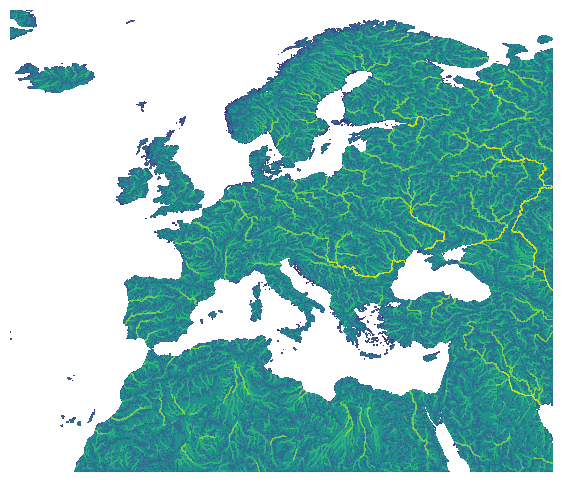

In [5]:
# visualise the results
plot(accuflux_field)

# Subcatchments & Catchments

In [6]:
# create or load the points of interest
points = np.zeros(network.mask.shape)
points[1801, 4529] = 5  # largest catchment's sink
points[886, 3999] = 2  # point within largest catchment but not the sink
points[1621, 3298] = 1  # separate catchment

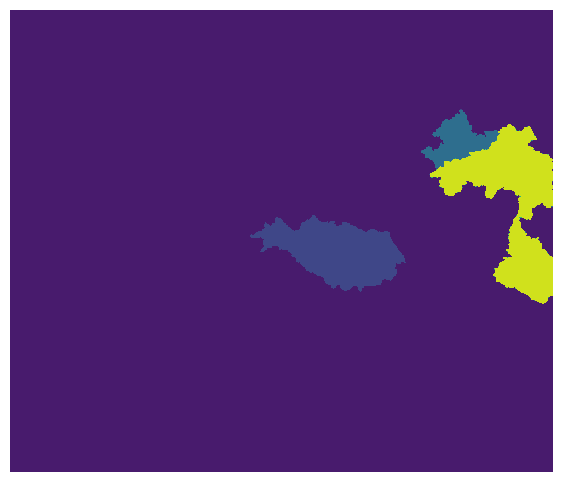

In [7]:
# find and plot the subcatchments
subcatchment_field = network.subcatchment(points)

plot(subcatchment_field, norm=None)

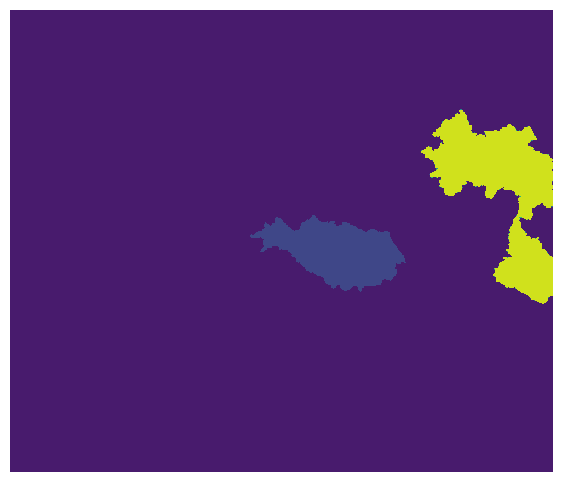

In [8]:
# find and plot the catchments
# note: the subcatchment has been overwritten
catchment_field = network.catchment(points)

plot(catchment_field, norm=None)

# Subnetwork

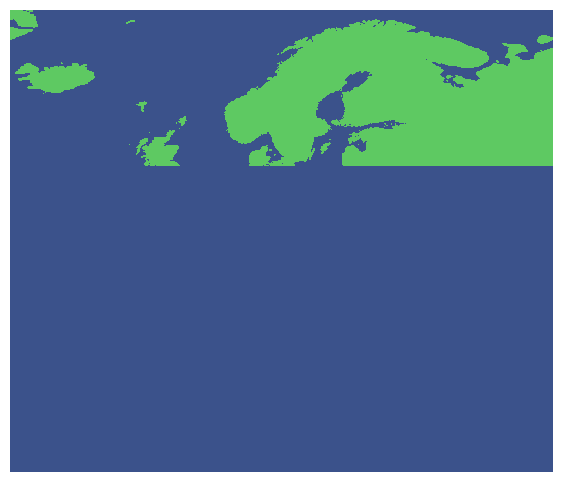

In [9]:
# create a subnetwork given a mask of northern Europe
mask = np.full(network.mask.shape, False)
mask[:1000] = True
north_europe_network = network.create_subnetwork(mask)

plot(north_europe_network.mask, norm=None)

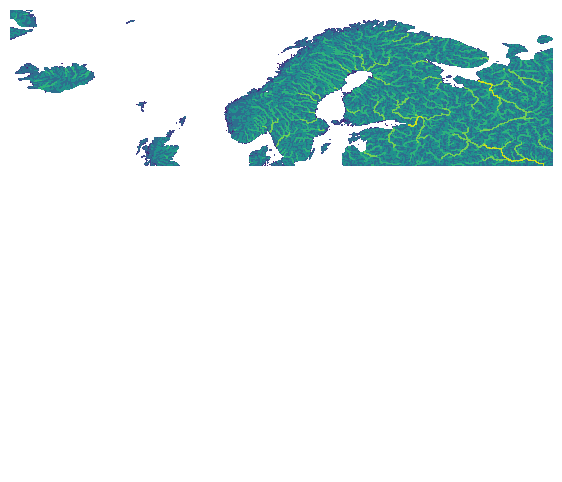

In [10]:
# conduct accuflux on the subnetwork
accuflux_field = north_europe_network.accuflux(unit_field)
plot(accuflux_field)

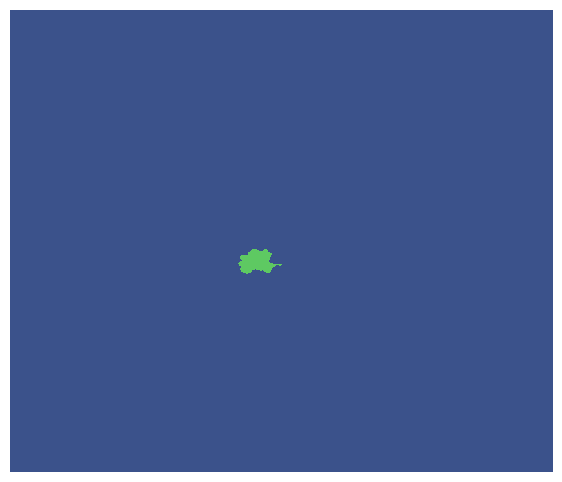

In [11]:
# create a subnetwork of a river catchment
# can find the mask directly by doing catchment with boolean arrays
points = np.full(network.mask.shape, False)
points[1636, 2267] = True  # Po river catchment sink
catchment_mask = network.catchment(points, mv=False)
po_catchment_network = network.create_subnetwork(catchment_mask)
plot(po_catchment_network.mask, norm=None)

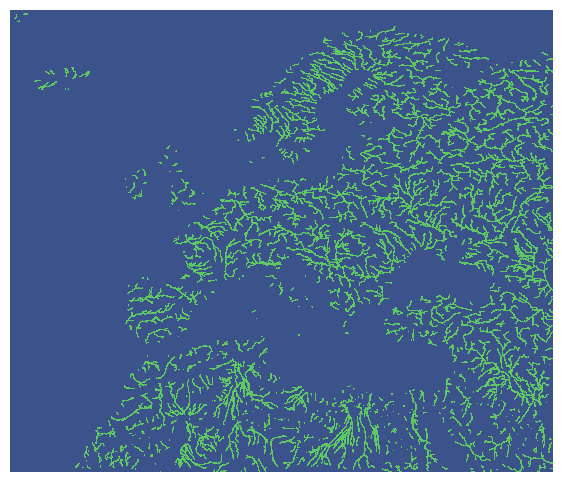

In [12]:
# create a subnetwork of large rivers only
accuflux_field = network.accuflux(unit_field)
large_rivers = accuflux_field > 1000
large_river_network = network.create_subnetwork(large_rivers)
plot(large_river_network.mask, norm=None)

# Upstream & Downstream

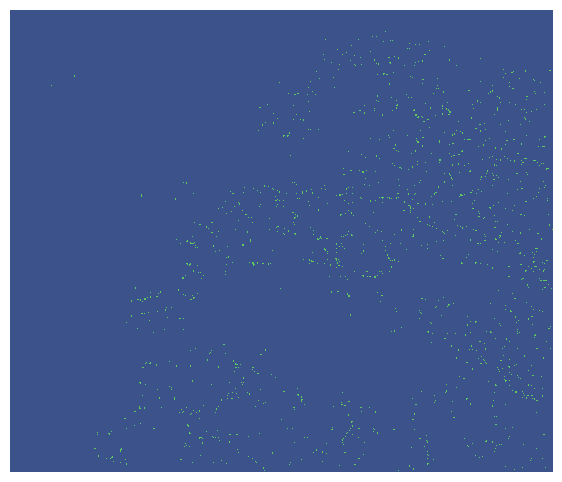

In [13]:
# find confluences of the large rivers
upstream_field = large_river_network.upstream(unit_field)
plot(upstream_field > 1, norm=None)

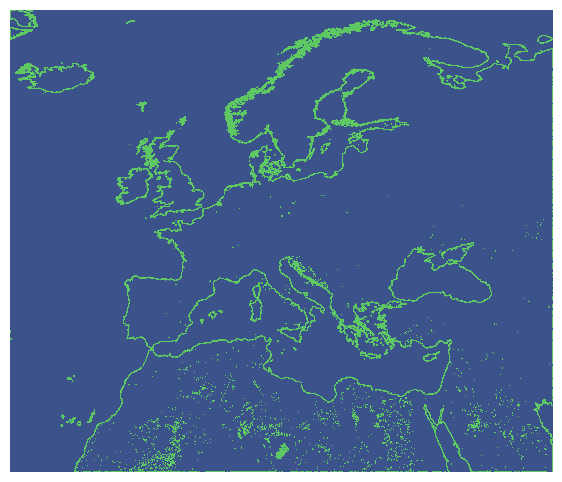

In [14]:
# find sinks of the original river network
downstream_field = network.downstream(unit_field)
plot(downstream_field == 0, norm=None)

# Example with Earthkit and Precipitation Maps

In [15]:
style = ekp.styles.Style(
    colors="Blues",
    levels=[0, 0.5, 1, 2, 5, 10, 50, 100, 500, 1000, 2000, 3000, 4000],
    extend="max",
)

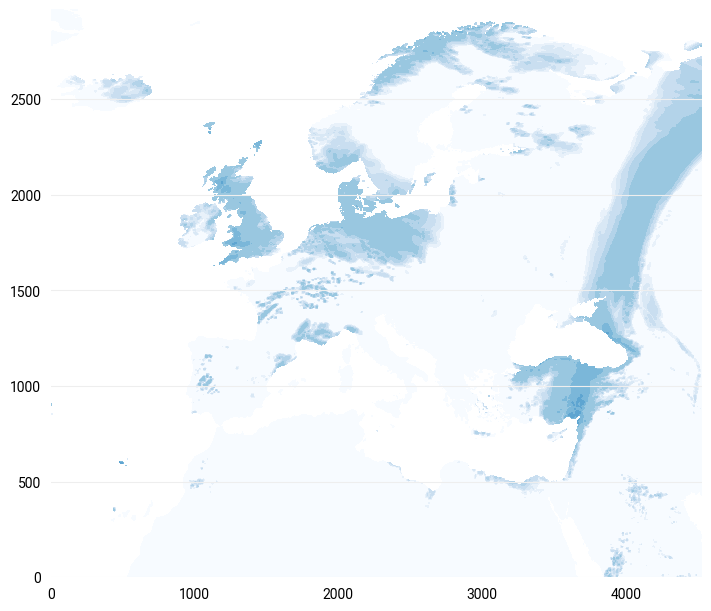

In [18]:
precipitation_field = ekd.from_source(
    "file", "/ec/ws4/tc/emos/work/cems/floods/efas/emos/efas/europe5km/202411/EUD2024112400/forcings/R06a.nc"
)[0].to_numpy()

qplot.contourf(precipitation_field[::-1, :], style=style)

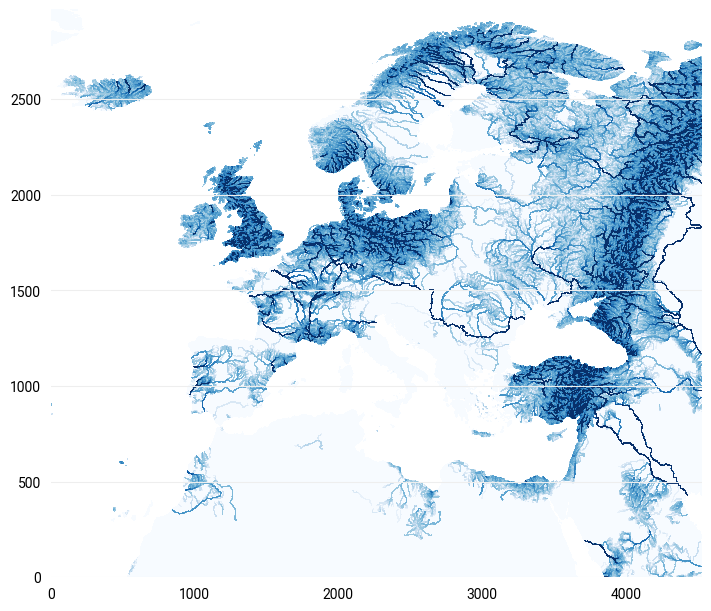

In [19]:
accuflux_field = network.accuflux(precipitation_field)
qplot.contourf(accuflux_field[::-1, :], style=style)